<a href="https://colab.research.google.com/github/andreaeliasc/Lab5-DataScience/blob/main/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autores: <br>
Andrea Elías - 17048 <br>
Diego Estrada - 18540 <br>
Saúl Contreras - 18409 <br>

# Laboratorio 5: Análisis de sentimientos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!pip install emoji

     |████████████████████████████████| 184 kB 8.3 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=9ff102b83e75f7421ea8c6475522c90c9f9e17430dedfaaf6e7538e1387e2551
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import hstack
from wordcloud import WordCloud, STOPWORDS

import warnings
import string
import re
import emoji
import nltk
from nltk.corpus import stopwords
color = sns.color_palette()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Preprocesamiento y Análisis exploratorio


In [ ]:
data = pd.read_csv('/content/drive/My Drive/datasets/GrammarandProductReviews/GrammarandProductReviews.csv')

In [ ]:
# Quitar conjunciones
stop_words = set(stopwords.words('english'))

In [ ]:
def quitar_signos(text):
    return text.translate(text.maketrans('', '', string.punctuation))

def quitar_url(text):
    return re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)

In [ ]:
# Quitar espacios vacios
data = data.dropna(subset=['reviews.text'])
# Convertir todo a minuscula
data['reviews.text'] = data['reviews.text'].apply(lambda line: str(line).lower())
# Quitar signos de puntuacion
data['reviews.text'] = data['reviews.text'].apply(lambda line: quitar_signos(str(line)))
# Quitar url's
data['reviews.text'] = data['reviews.text'].apply(lambda line: quitar_url(str(line)))
# Quitar emojis
data['reviews.text'] = data['reviews.text'].apply(lambda line: emoji.demojize(str(line)))

In [ ]:
data.head(5)

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",2017-07-25T00:52:42Z,2018-02-05T08:36:58Z,6.02537E+11,"602537205981,universalmusic/14331328,universal...",Universal Music Group / Cash Money,14331328,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,2018-02-04T07:28:12Z,"2018-01-15T04:45:00.000Z,2018-01-18T14:30:00.0...",NaN,NaN,NaN,0.0,5,https://redsky.target.com/groot-domain-api/v1/...,i love this album its very good more to the hi...,Just Awesome,Los Angeles,NaN,Joshua,6.02537E+11
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-23T02:53:06Z,2017-09-16T09:45:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,good flavor this review was collected as part ...,Good,NaN,NaN,Dorothy W,73416000391
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",2017-07-25T05:16:03Z,2018-02-05T11:27:45Z,73416000391,lundbergorganiccinnamontoastricecakes/b000fvzw...,Lundberg,574764,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,2017-09-06T04:49:31Z,2017-08-23T10:37:00.000Z,True,NaN,100209113.0,NaN,5,https://www.walmart.com/reviews/product/29775278,good flavor,Good,NaN,NaN,Dorothy W,73416000391
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,2017-09-11T17:13:57Z,"2017-09-04T12:18:00.000Z,2017-08-09T02:12:00.000Z",False,False,113026909.0,NaN,1,https://www.walmart.com/reviews/product/43383370,i read through the reviews on here before look...,Disappointed,NaN,NaN,Rebecca,67981934427
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",2017-07-25T16:26:19Z,2018-02-05T11:25:51Z,67981934427,"kylovesensualitypleasuregel/b00u2whx8s,0679819...",K-Y,67981934427,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,2017-09-11T17:13:57Z,"2017-09-04T12:18:00.000Z,2017-08-09T02:12:00.000Z",False,False,171267657.0,NaN,1,https://www.walmart.com/reviews/product/43383370,my husband bought this gel for us the gel caus...,Irritation,NaN,NaN,Walker557,67981934427


In [ ]:
data.tail(5)

,id,brand,categories,dateAdded,dateUpdated,ean,keys,manufacturer,manufacturerNumber,name,reviews.date,reviews.dateAdded,reviews.dateSeen,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,upc
71039,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,2012-03-25T00:00:00.000Z,2017-09-11T17:13:57Z,2017-09-04T12:20:16.660Z,False,True,6855681.0,6.0,5,https://www.walmart.com/reviews/product/10294231,im dealing with dry eyes and very sensitive to...,Solves the problem,NaN,NaN,Seniorgal,"300650361040,631113253665,300650193108,3006503..."
71040,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,2015-12-07T00:00:00.000Z,2017-09-11T17:13:57Z,2017-09-04T12:20:16.660Z,False,True,71102868.0,1.0,5,https://www.walmart.com/reviews/product/10294231,great stuff helps keep my contacts moist all day,Great stuff!,NaN,NaN,Nammaw,"300650361040,631113253665,300650193108,3006503..."
71041,AVzRGDlw-jtxr-f3yfFH,Opti-Free,"Personal Care,Eye & Ear Care,Eye Care,Contact ...",2017-06-22T18:37:24Z,2018-02-05T11:28:36Z,"3,006,503,610,570,300,000,000,000,000,000,000,...",optifreepuremoistdisinfectingsolution10floz/b0...,Opti-Free,11014438,Opti-Free Puremoist Disinfecting Solution 10fl Oz,2015-07-23T00:00:00.000Z,2017-09-11T17:13:57Z,2017-09-04T12:20:16.660Z,False,True,58039428.0,0.0,5,https://www.walmart.com/reviews/product/10294231,right price,My review,NaN,NaN,LDBoston,"300650361040,631113253665,300650193108,3006503..."
71042,AVzvTLfivKc47QAVfPme,Bebe Au Lait,"Baby,Nursing & Feeding,Breastfeeding,Nursing C...",2017-06-28T15:23:21Z,2018-02-05T10:19:41Z,8.78982E+11,"878982005883,bebeaulait/50032623,0878982005883...",Bebe au Lait,50032623,Bebe Au Lait174 Premium Muslin Nursing Scarf -...,2016-01-19T18:28:16.000Z,2018-02-05T10:19:41Z,"2018-01-16T00:14:00.000Z,2018-01-22T07:10:00.0...",NaN,True,NaN,1.0,5,https://redsky.target.com/groot-domain-api/v1/...,i was so pleased when this scarf arrived for m...,Wonderful Product,NaN,NaN,Vanessag,8.78982E+11
71043,AVzvWCVKglJLPUi8Gzji,UMGD,"Movies, Music & Books,Music,Gospel & Christian...",2017-06-28T15:35:50Z,2018-02-05T10:21:34Z,"6,025,476,958,640,600,000,000,000","602547970220,602547695871,602547695864,6025476...",Def Jam,51590070,Justin Bieber - Under The Mistletoe (vinyl),2017-01-12T23:12:46.000Z,2018-01-19T06:21:55Z,"2018-01-18T14:35:00.000Z,2017-12-20T12:37:00.0...",NaN,True,NaN,1.0,5,https://redsky.target.com/groot-domain-api/v1/...,excellent album makes the holidays better give...,Makes The Holidays Better,NaN,NaN,Chrismas Bieber,"602,547,970,220,602,000,000,000,000,000,000,00..."


In [ ]:
table = data.groupby("brand").size().reset_index(name="Frecuencia").sort_values(['Frecuencia'], ascending=False)
table

,brand,Frecuencia
80,Clorox,10700
360,Universal Home Video,6178
343,Tide,5384
105,FOX,4498
96,Disney,3692
...,...,...
132,Honey Bunches of Oats,1
309,SoBe,1
136,Horizon,1
138,Hortense B. Hewitt,1


In [ ]:
table = pd.crosstab(data.brand, data['reviews.rating'])
table

reviews.rating,1,2,3,4,5
brand,,,,,
4C Foods,0,0,0,0,6
AMBI,0,0,0,1,3
ANCHOR BAY,0,0,1,5,24
Adesso,0,0,0,0,2
Advantage,0,0,0,3,0
...,...,...,...,...,...
Yes to Grapefruit,5,1,6,10,17
Yosemite Home Decor,1,0,0,0,0
Zyliss,2,2,2,3,50


##Nubes de Palabras

Se buscara realizar nubes de palabras, para encontrar las palabras mas repetidas en reviews buenos (3 estrellas o mas), revies neutros (3 estrellas), revies malos (menos de 3 estrellas).



In [ ]:
data['reviews.text'].head()

0    i love this album its very good more to the hi...
1    good flavor this review was collected as part ...
2                                          good flavor
3    i read through the reviews on here before look...
4    my husband bought this gel for us the gel caus...
Name: reviews.text, dtype: object

Palabras en general

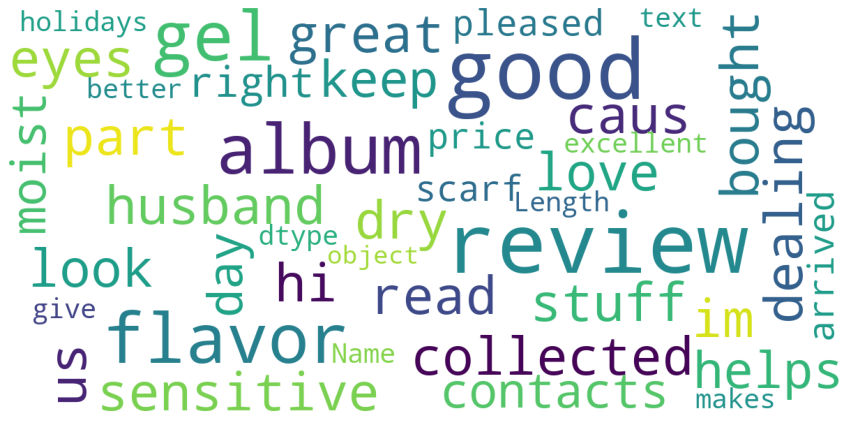

In [ ]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(data['reviews.text']))
fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Reviews Buenos

In [ ]:
palabras_positivas = data.loc[data['reviews.rating']>3, ['reviews.text']]
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(palabras_positivas))
fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Reviews Neutros

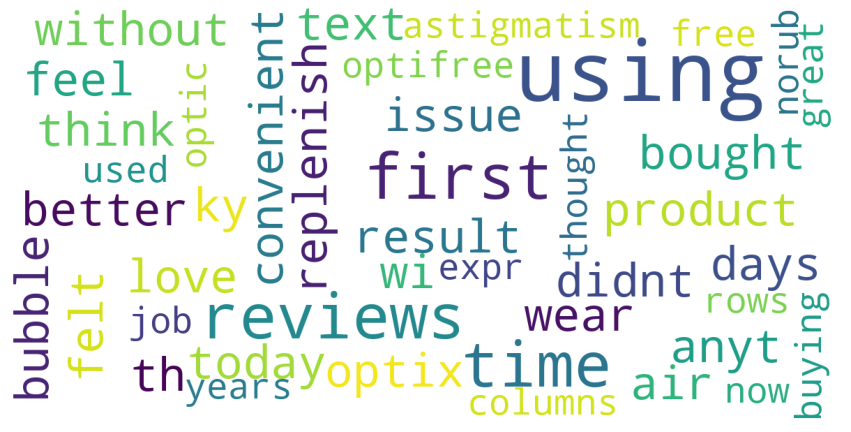

In [ ]:
palabras_neutras = data.loc[data['reviews.rating']==3, ['reviews.text']]
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(palabras_neutras))
fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Reviews malos

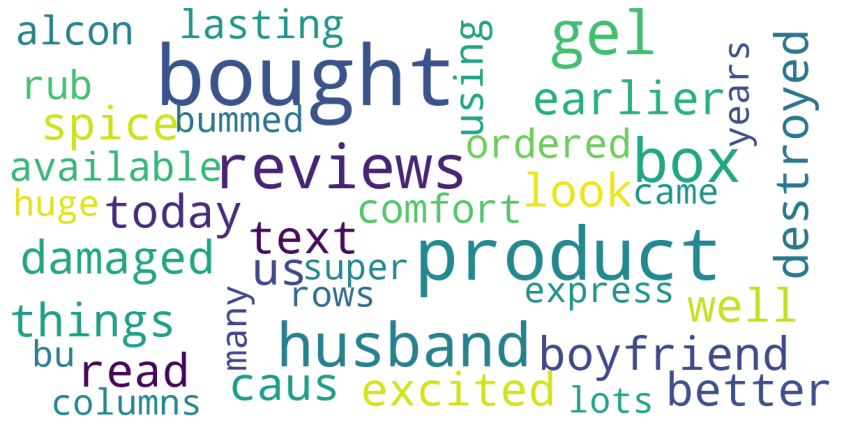

In [ ]:
palabras_negativas = data.loc[data['reviews.rating']<3, ['reviews.text']]
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1).generate(str(palabras_negativas))
fig = plt.figure(1, figsize=(15, 15))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

##Histograma de palabras segun estrellas

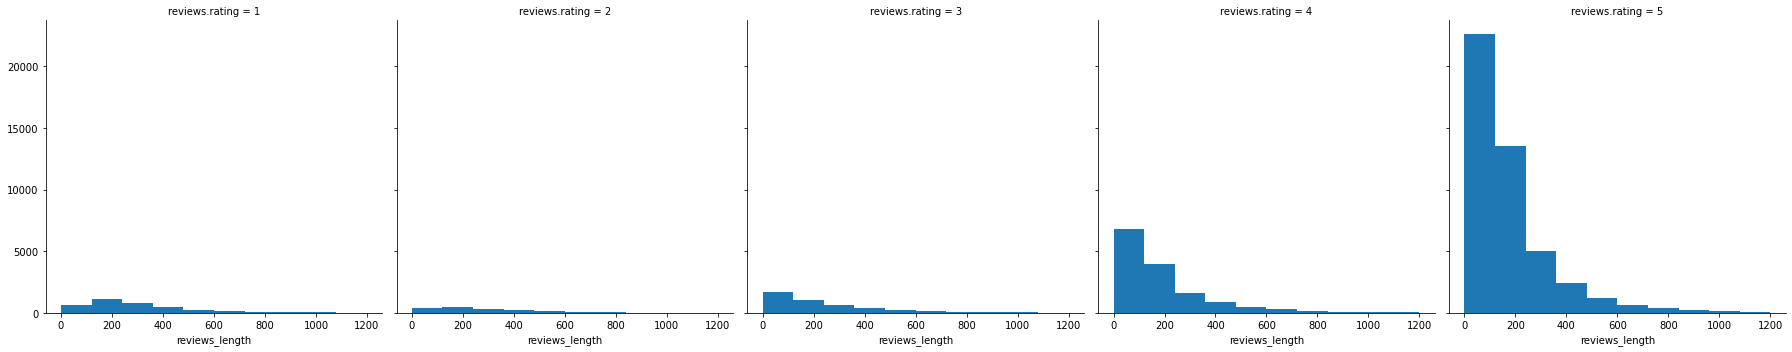

In [ ]:
data['reviews_length'] = data['reviews.text'].apply(len)
g = sns.FacetGrid(data,col='reviews.rating',height=5)
g.map(plt.hist,'reviews_length', range=(0, 1200))

# Clasificación de las palabras

Clasificación de las palabras en positivas, negativas y neutrales. Los datos que se utilizaron para realizar dicha acción son provenientes de lexicon, que se encuentran en este repositorio 'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt'.  Aca se puede encontrar varias variables, pero nos concetraremos en termino y sentimiento que nos devolvera una puntuación sentimental para cada palabra. Además de que se convinaron los textos de el título del review y el texto del mismo para poder tener un mejor acercamiento. 

In [67]:
buenas = {}
malas = {}
neutras = {}

In [68]:
for review, classType in zip(data['reviews.text'], data['reviews.rating']):
    text = review.split(' ')
    for word in text:
        if word not in stop_words and word != '':
            if classType > 3:
                cont = buenas.get(word)
                if cont:
                    buenas[word] = cont + 1
                else:
                    buenas[word] = 1
            elif classType < 3:
                cont = malas.get(word)
                if cont:
                    malas[word] = cont + 1
                else:
                    malas[word] = 1
            elif classType == 3:
                cont = neutras.get(word)
                if cont:
                    neutras[word] = cont + 1
                else:
                    neutras[word] = 1

In [72]:
buenas.keys()

dict_keys(['love', 'album', 'good', 'hip', 'hop', 'side', 'current', 'pop', 'sound', 'hype', 'listen', 'everyday', 'gym', 'give', '5star', 'rating', 'way', 'metaphors', 'crazy', 'flavor', 'review', 'collected', 'part', 'promotion', 'noticed', 'product', 'clearance', 'store', 'shop', 'frequently', 'decided', 'try', 'husband', 'went', 'back', 'bought', 'every', 'box', 'left', 'like', 'others', 'mentioned', 'sure', 'supposed', 'lubricant', 'purpose', 'much', 'better', 'regular', 'ky', 'jelly', 'tends', 'dry', 'disappear', 'us', 'stays', 'awhile', 'makes', 'pleasurable', 'experience', 'drawback', 'find', 'bit', 'sticky', 'applying', 'hands', 'youre', 'hand', 'agree', 'little', 'goes', 'long', 'personally', 'careful', 'products', 'due', 'skin', 'irritation', 'surprisingly', 'actually', 'seems', 'help', 'receive', 'sample', 'never', 'used', 'couple', 'times', 'since', 'recived', 'free', 'experiance', 'feel', 'warm', 'pretty', 'sensation', 'recomend', 'bad', 'loved', 'great', 'feeling', 'real

In [73]:
len(buenas.keys())

31286

In [70]:
malas.keys()

dict_keys(['read', 'reviews', 'looking', 'buying', 'one', 'couples', 'lubricants', 'ultimately', 'disappointed', 'didnt', 'even', 'live', 'starters', 'neither', 'boyfriend', 'could', 'notice', 'sort', 'enhanced', 'captivating', 'sensation', 'however', 'messy', 'consistency', 'reminiscent', 'liquidy', 'vaseline', 'difficult', 'clean', 'pleasant', 'especially', 'since', 'lacked', 'expecting', 'im', 'paid', 'much', 'lube', 'wont', 'use', 'normal', 'personal', 'lubricant', '1', 'less', 'money', '2', 'mess', 'husband', 'bought', 'gel', 'us', 'caused', 'irritation', 'felt', 'like', 'burning', 'skin', 'wouldnt', 'recommend', 'spice', 'things', 'bedroom', 'highly', 'product', 'absolutely', 'love', 'ky', 'mine', 'thought', 'would', 'similar', 'affect', 'nothing', 'buy', 'earlier', 'today', 'excited', 'check', 'based', 'description', 'something', 'regular', 'fans', 'expected', 'left', 'little', 'try', 'impressed', 'tingling', 'warming', 'sticky', 'used', 'products', 'past', 'loved', 'disappointi

In [74]:
len(malas.keys())

10827